In [57]:
ALPACA_API_KEY = "PKVQE7BUOAC40D5OSCHH"
ALPACA_SECRET_KEY = "DfXHYuZpMlmON3mcHPVTQDWZTnnMyt95PyaDtlAF"

In [58]:
current_ticker = 'UBER'

In [59]:
company_ticker = {
    'SQ': {'start-date': "2019-05-01", 'end-date': '2021-06-27'},
    'ENPH': {'start-date': "2019-05-01", 'end-date': '2021-06-27'},
    'UBER': {'start-date': "2020-05-01", 'end-date': '2021-06-27'}
}

In [60]:
from sklearn.preprocessing import MinMaxScaler
import alpaca_trade_api as tradeapi
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [61]:
api = tradeapi.REST(
   ALPACA_API_KEY,
   ALPACA_SECRET_KEY,
   api_version = "v2"
)

In [62]:
def split_data(X, Y, lookback, split_ratio):
    
    data = []

    for index in range(len(X) - lookback): 
        data.append(X[index: index + lookback])

    data = np.array(data);
    test_set_size = int(np.round(split_ratio * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    print(data.shape, Y.shape)

    x_train = data[:train_set_size,:]
    y_train = Y[:train_set_size,:]
    
    x_test = data[train_set_size:,:]
    y_test = Y[train_set_size+lookback:,:]
    
    return [x_train, y_train, x_test, y_test]

In [63]:
df_tickers = {}
for ticker, dates in company_ticker.items():
  # Set timeframe to '1D'
  timeframe = "1D"
  # Set start and end datetimes between now and 3 years ago.
  start_date = pd.Timestamp(dates['start-date'], tz="America/New_York").isoformat()
  end_date = pd.Timestamp(dates['end-date'], tz="America/New_York").isoformat()
  # Get 3 year's worth of historical price data for Microsoft and Coca-Cola
  df_ticker = api.get_barset(
      [ticker],
      timeframe,
      start=start_date,
      end=end_date,
      limit=1000,
  ).df
  df_tickers[ticker] = df_ticker

In [64]:
df = df_tickers[current_ticker][current_ticker]

In [79]:
df

,open,high,low,close,volume
time,,,,,
2020-05-01 00:00:00-04:00,29.13,29.7200,28.325,28.39,37302772
2020-05-04 00:00:00-04:00,27.56,28.0700,26.580,27.42,45657236
2020-05-05 00:00:00-04:00,28.25,28.9088,27.440,28.08,57098898
2020-05-06 00:00:00-04:00,27.50,28.0600,26.810,27.85,53434735
2020-05-07 00:00:00-04:00,29.60,31.6500,29.580,30.89,97664400
...,...,...,...,...,...
2021-06-21 00:00:00-04:00,49.74,49.8600,47.900,48.12,27047070
2021-06-22 00:00:00-04:00,48.35,49.3400,47.750,49.06,16960328
2021-06-23 00:00:00-04:00,49.06,50.7700,49.010,50.53,18987768


In [65]:
X = df.to_numpy()
print (X)

[[2.9130000e+01 2.9720000e+01 2.8325000e+01 2.8390000e+01 3.7302772e+07]
 [2.7560000e+01 2.8070000e+01 2.6580000e+01 2.7420000e+01 4.5657236e+07]
 [2.8250000e+01 2.8908800e+01 2.7440000e+01 2.8080000e+01 5.7098898e+07]
 ...
 [4.9060000e+01 5.0770000e+01 4.9010000e+01 5.0530000e+01 1.8987768e+07]
 [5.1300000e+01 5.1550000e+01 5.0220000e+01 5.0830000e+01 1.1644976e+07]
 [5.1150000e+01 5.1830000e+01 5.0530000e+01 5.1680000e+01 1.5074888e+07]]


In [66]:
price = df[["close"]]
price_scaler = MinMaxScaler(feature_range=(-1,1))
all_scaler = MinMaxScaler(feature_range=(-1,1))
Y = price_scaler.fit_transform(price["close"].values.reshape(-1,1))
X = all_scaler.fit_transform(X)

In [67]:
print(X.shape, Y.shape)

(291, 5) (291, 1)


In [68]:
lookback = 40 # sequence length
split_ratio = 0.1
x_train, y_train, x_test, y_test = split_data(X, Y, lookback, split_ratio)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(251, 40, 5) (291, 1)
(226, 40, 5) (226, 1)
(25, 40, 5) (25, 1)


In [69]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [70]:
input_dim = 5
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100
learning_rate = 0.01

In [71]:
class MyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(MyModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [72]:
model = MyModel(input_dim = input_dim, hidden_dim = hidden_dim, num_layers = num_layers, output_dim = output_dim)
loss_func = torch.nn.MSELoss(reduction='mean')
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

# The Training Loop

In [73]:
start_time=time.time()
for e in range(num_epochs):
  y_train_pred = model(x_train)
  loss = loss_func(y_train_pred, y_train)
  print(f"Epoch: {e}\tLoss: {loss.item()}")
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
elapsed_time = time.time() - start_time
print(f"Total time for training: {elapsed_time}")

Epoch: 0	Loss: 0.5019183158874512
Epoch: 1	Loss: 0.34479570388793945
Epoch: 2	Loss: 0.21853014826774597
Epoch: 3	Loss: 0.17353364825248718
Epoch: 4	Loss: 0.14477449655532837
Epoch: 5	Loss: 0.10804803669452667
Epoch: 6	Loss: 0.1177021786570549
Epoch: 7	Loss: 0.13358399271965027
Epoch: 8	Loss: 0.12898777425289154
Epoch: 9	Loss: 0.11737456917762756
Epoch: 10	Loss: 0.10552258044481277
Epoch: 11	Loss: 0.09394139796495438
Epoch: 12	Loss: 0.08144377171993256
Epoch: 13	Loss: 0.06223495304584503
Epoch: 14	Loss: 0.07298305630683899
Epoch: 15	Loss: 0.0718967542052269
Epoch: 16	Loss: 0.05162633955478668
Epoch: 17	Loss: 0.03797869384288788
Epoch: 18	Loss: 0.03813454881310463
Epoch: 19	Loss: 0.04529283195734024
Epoch: 20	Loss: 0.05193336308002472
Epoch: 21	Loss: 0.03794550150632858
Epoch: 22	Loss: 0.034894559532403946
Epoch: 23	Loss: 0.035154324024915695
Epoch: 24	Loss: 0.03427532687783241
Epoch: 25	Loss: 0.03256966918706894
Epoch: 26	Loss: 0.031027667224407196
Epoch: 27	Loss: 0.031937628984451294
E

## Test Loss

In [74]:
with torch.no_grad():
    y_test_pred = model(x_test)
    print(y_test_pred.shape, y_test.shape)
    loss = loss_func(y_test_pred, y_test)
    print(f"Test\tLoss: {loss.item()}")

torch.Size([25, 1]) torch.Size([25, 1])
Test	Loss: 0.043408144265413284


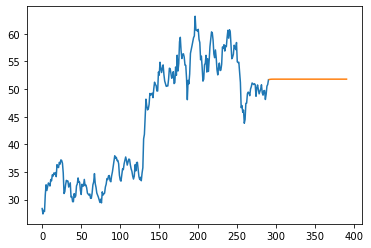

array([51.73744142, 51.76732241, 51.78286648, 51.79095249, 51.79515883,
       51.79734697, 51.79848523, 51.79907736, 51.79938538, 51.79954562,
       51.79962897, 51.79967233, 51.79969488, 51.79970662, 51.79971272,
       51.7997159 , 51.79971755, 51.79971841, 51.79971886, 51.79971909,
       51.79971921, 51.79971927, 51.7997193 , 51.79971932, 51.79971933,
       51.79971933, 51.79971934, 51.79971934, 51.79971934, 51.79971934,
       51.79971934, 51.79971934, 51.79971934, 51.79971934, 51.79971934,
       51.79971934, 51.79971934, 51.79971934, 51.79971934, 51.79971934,
       51.79971934, 51.79971934, 51.79971934, 51.79971934, 51.79971934,
       51.79971934, 51.79971934, 51.79971934, 51.79971934, 51.79971934,
       51.79971934, 51.79971934, 51.79971934, 51.79971934, 51.79971934,
       51.79971934, 51.79971934, 51.79971934, 51.79971934, 51.79971934,
       51.79971934, 51.79971934, 51.79971934, 51.79971934, 51.79971934,
       51.79971934, 51.79971934, 51.79971934, 51.79971934, 51.79

In [95]:
from statsmodels.tsa.arima.model import ARIMA

arma_data = df[["close"]].to_numpy().flatten()
arma_model = ARIMA(arma_data, order=(1,1,1))
results = arma_model.fit().forecast(steps=100)
#full_results = np.concatenate((arma_data, results.forecast(steps=10)))

plt.plot(np.arange(len(arma_data)), arma_data)

plt.plot(np.arange(len(arma_data), len(arma_data)+len(results)), results)
plt.show()
results
#pd.DataFrame(results.forecast(steps=10)[0]).plot(title="Stock Return Forecast")

# Prediction for Tomorrow

In [ ]:
past_actual_price = price_scaler.inverse_transform(y_train)
future_actual_price = price_scaler.inverse_transform(y_test)

future_prediction_price = price_scaler.inverse_transform(model(x_test).detach().numpy())

actual_price = np.vstack((past_actual_price, future_actual_price)).reshape(1, -1)[0]
prediction_price = np.vstack((past_actual_price, future_prediction_price)).reshape(1, -1)[0]

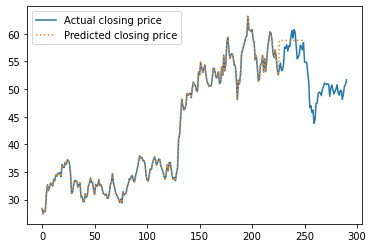

In [ ]:
%matplotlib inline

plt.plot(actual_price, label='Actual closing price')
plt.plot(prediction_price, ':', label='Predicted closing price')
plt.legend();

In [ ]:
print(future_prediction_price.reshape(1,-1)[0])

[58.803947 58.800488 58.801086 58.800713 58.79904  58.79649  58.797977
 58.799335 58.801502 58.79972  58.808464 58.810875 58.806797 58.808773
 58.812725 58.81569  58.814663 58.811035 58.812492 58.815292 58.81507
 58.809517 58.811775 58.812725 58.80095 ]
